# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    
    # importing bad words 
    badwords = set(line.strip() for line in open('badwords.txt'))
    import nltk
    tokenized_sents = pd.Series([]) 
    toxic_data['tokenized_sents'] = toxic_data.apply(lambda row: nltk.word_tokenize(row['comment_text']), axis=1)

    toxicValues = []
    sentencePosition = []
    arraylength = len (toxic_data['tokenized_sents'])
    for index in range(0,arraylength):
        sentencePosition.append(index)
        badDetected = 0
        for word in toxic_data['tokenized_sents'][index]:
            word = word.lower()
            if word in badwords:
                badDetected =1
        if badDetected:
            toxicValues.append(1)
        else:
            toxicValues.append(0)

    toxicValues = np.array(toxicValues)
    sentencePosition = np.array(sentencePosition)
    temp = pd.Series(data=toxicValues, index=sentencePosition)
    print(toxicValues)
    print(sentencePosition)
    print(temp)
    
    
    toxic_data.insert(2, "temp", temp) 

    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    toxic_data['punc_count1'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\?")
    toxic_data['punc_count3'] = toxic_data['comment_text'].str.count("\*")
    toxic_data['punc_count4'] = toxic_data['comment_text'].str.count("\$")
    toxic_data['punc_count6'] = toxic_data['comment_text'].str.count("\_")
    toxic_data['punc_count7'] = toxic_data['comment_text'].str.count("\00")
    toxic_data['punc_count5'] = toxic_data['comment_text'].str.len()


    X_quant_features = toxic_data[["temp","word_count",'punc_count','punc_count1','punc_count2','punc_count3','punc_count4','punc_count5', 'punc_count6', 'punc_count7']]

    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
        
        
        
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:

# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []




# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../final_data/toxiccomments_train.csv', my_random_seed=11)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [6]:
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X_train, y_train)

# svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
# svm_performance_train.compute_measures()
# print(svm_performance_train.performance_measures)

### MODEL: logistic regression

In [7]:
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log')
# lgs.fit(X_train, y_train)

# lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
# lgs_performance_train.compute_measures()
# print(lgs_performance_train.performance_measures)

### MODEL: Naive Bayes

In [8]:
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X_train, y_train)

# nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
# nbs_performance_train.compute_measures()
# print(nbs_performance_train.performance_measures)

### MODEL: Perceptron

In [9]:
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X_train, y_train)

# prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
# prc_performance_train.compute_measures()
# print(prc_performance_train.performance_measures)

### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha= 100.0,
 class_weight= None,
 copy_X= True,
 fit_intercept= True,
 max_iter= None,
 normalize= True,
 random_state=11,
 solver= 'auto',
 tol= 0.001)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12462, 'TN': 108490, 'FP': 6216, 'FN': 488, 'Accuracy': 0.947483862881494, 'Precision': 0.6672020558946354, 'Recall': 0.9623166023166023, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

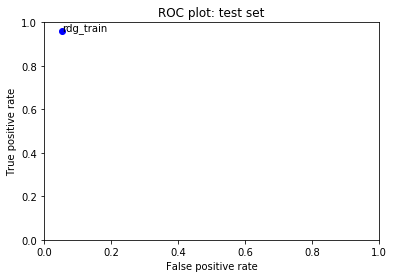

In [12]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
437
Whatever you want to believe.
* * * * * * * * * 
759
~ J.Lo
* * * * * * * * * 
947
Stick it right up ur bottom Jock!
* * * * * * * * * 
1116
dont abuse your power
* * * * * * * * * 
1477
nothing 

Moot wants to be the little girl
* * * * * * * * * 
1837
"

"
* * * * * * * * * 
2187
God 

I have learned for myself that your beliefs are not true. Seeing what you're doing right now, I think that you will regret living your life.
* * * * * * * * * 
2609
. i run the biggest fansite for tossgirl, so i dont know why ur trying to accuse my correctyions as vandalism
* * * * * * * * * 
2650
Stopped being funny? 

It never stops being funny.  It's even funnier now because it pisses you off ) Have a nice day!
* * * * * * * * * 
3389
Sorry don't do blocks 

I'm really sorry.,.. I don't do blocks. I have 31 ISPs with many ranges. Thanks though.

YourCousin
* * * * * * * * * 
4035
SmackBot 

What do you know about Father's Rights???? I'm one of the guys who invented i

20790
"
Clearly reading isn't a thing for you.  Your article says no such thing but hey, why let reality piss on your party right?  Your article here doesn't say what you claim.  It does NOT say the GOP admits to the ""Southern Strategy""."
* * * * * * * * * 
21235
Malcolm? Is it really you? 

Man who...
* * * * * * * * * 
21241
Thanks everyone
Unacceptable. What a mess. Clean it up, and stop prevaricating on the straightforward truth. She was notorious, and had many people fooled. This writing ought to reflect that. Also, whoever you are, STOP deleting my posts herelike I really care, they'll be read anyway.75.21.101.63
* * * * * * * * * 
21579
They are paying some of the girls to be there.  It's usually the ones who imeidatly start giving the male dancers oral sex or having sex with them on stage.  The idea is that they give a good show and encourage the rest of the ladies in the audience to follow.
* * * * * * * * * 
21937
"Block evasion. May need lengthening + range block. Old trol

42965
Schumin and DC  

Hi, I don't think Ben can go along to the DC meetup. The last one he was at he was too fat to sit on the chair so everyone had to go outside and sit on concrete blocks instead. He also had that irritating video camera with him and sneakily took video footage of the male crotch region - that seems to be his thing, the poor sod. Generally speaking the guy is a creep who thinks its cool to take video footage of everything - I reccomend you keep well away from him.
* * * * * * * * * 
43278
Keep talkin Niteshift.
* * * * * * * * * 
43730
Lol. Reminds me the movie Dumb and Dumber.
* * * * * * * * * 
43917
Lol, you are too busy doing what now?   Maybe you don't realize it, but no one gives a shit about anything you're doing, because it's a waste of time and no one will ever read it
* * * * * * * * * 
44151
"of birds form the planet Asia. Dogs were worshiped as dinosaurs because of their large tails. No two dogs smelled the same, until the great dog migration of 2021. A

55324
Noob 

That wasn't vandalism, that was true. i go to the school so i should know
* * * * * * * * * 
55371
OMG 

Robert I'm your #1 fan!
* * * * * * * * * 
56621
Didn't you like my present? 

Here's a fresh one, if you got the last one dirty...

 216.164.33.62
* * * * * * * * * 
56816
I cannot wait for this ban to end. I love how User:Kiand can get away with vandalism.
* * * * * * * * * 
58121
Quit hounding me, Dominick.
* * * * * * * * * 
58440
,  (who IS better than you are)
* * * * * * * * * 
58526
Great, just glad to have that crappy remake off the page of a good classic movie.
* * * * * * * * * 
59485
hey bro 

hey I've recently edited Crimea, tell me what do you think of the new article ?
* * * * * * * * * 
59716
Highway of Life talk page.
* * * * * * * * * 
59744
hey there 

 STAY AWAY FROM 4CHAN
* * * * * * * * * 
59817
I did what you asked, but you are acting in a wrong way.
* * * * * * * * * 
59904
Makes me want to vomit
The way they're hand holding SPUI especially after

63240
"
Looks good, Cyphoidbomb! )  (talk) "
* * * * * * * * * 
63394
So what? That means nothing!
Get photography off of this page!
* * * * * * * * * 
63467
Oooooh. Thanks Buster. I eat turkey and ham, so thanks. We also sometimes eat rabbit on Thanksgiving. Mmmmmm. I can just taste it now!! Thanks again Buster7!
* * * * * * * * * 
63741
99.129.112.89   (posted 9:11 AM)
* * * * * * * * * 
64171
I'm talking about our issues. You know how you tried to ruin me. I want resolution to this issue. You make me out to be bad. I'm not. You tried to take me out. I will not forget this ever. I am your ally if you are good to me. But you were not good to me. I do not hate you. I hate what you did to me. Apologize to me and I will apologize to you. The ball is in your court.
* * * * * * * * * 
64236
"

Barnstar
  The RickK Anti-Vandalism Barnstar because you're a brave vandal fighter"
* * * * * * * * * 
64322
wow are you always on wikipedia?  doesnt your girlfriend mind? (just kidding i know you do

86242
"

 HOUND STALK HARASS - but that does not mean anything here 

  Yet such editors go unmarked at all - while it is a most grievous sin to point out that [Talk:Koch_family/Archive_1]  appears to violate WP:BLP on its face.  ""My fault, my fault, my most grievous fault"" for thinking that Wikipedia's most important policies are actually important, while folks like ""IP2600"" can go around stalking, hounding and harassing and no one does a single damn thing about them at all.         "
* * * * * * * * * 
87907
Then I guess you'd better run off to AN/I, get JohnCD blocked and reintroduce the vandalism I asked him to undo . -  ✉
* * * * * * * * * 
88473
User Ferret is harassing me 

He follows me around
* * * * * * * * * 
88625
Mountain View High School 

It's definitely true and verifiable, but if you want to be a Wikipedia Nazi on a power trip, go right ahead.  I have more important things to do in my life than fight you on this.
* * * * * * * * * 
89328
Keith Peter Wansadha Basali

116014
get on it, how dare they insult my waifu
* * * * * * * * * 
116139
Just Telling the truth

Sorry if the truth is uncomfortable.74.192.7.135
* * * * * * * * * 
116522
"

 No apology 

Just wanted to let you know that you represent the worst of what is poisoning this entire project, and will lead to it's eventual death; people unwilling, unable, and too goddamn slow and retarded to seperate out their own personal bagge and backwards ideals from what should be a wholly neutral thing. Keep pushing that GBW payroll cruft they have you pushing, and keep on giving him a rim job. Unless you're completely blind, deaf, and dumb, and don't realize that half the country's problems today are solely due to him and his little ""POV Pushing"" cabal. Sound familiar? Asshat.  (T) "
* * * * * * * * * 
117058
"== Hello! ==

How ya doin...    Hi ' "
* * * * * * * * * 
117400
Heaven or Hell?

What happen to Norman? Doctor Octopus died a hero, and most likely went to Heaven, Harry will die a hero. Wha

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [16]:
# svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
# svm_performance_test.compute_measures()
# print(svm_performance_test.performance_measures)

### MODEL: logistic regression

In [17]:
# lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
# lgs_performance_test.compute_measures()
# print(lgs_performance_test.performance_measures)

### MODEL: Naive Bayes

In [18]:
# nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
# nbs_performance_test.compute_measures()
# print(nbs_performance_test.performance_measures)

### MODEL: Perceptron

In [19]:
# prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
# prc_performance_test.compute_measures()
# print(prc_performance_test.performance_measures)

### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2852, 'TN': 26672, 'FP': 1968, 'FN': 423, 'Accuracy': 0.9250822497258342, 'Precision': 0.591701244813278, 'Recall': 0.8708396946564886, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

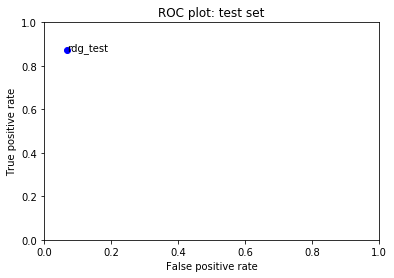

In [22]:
fits = [rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../final_data/toxiccomments_test.csv', my_random_seed=11, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1048576)
[1 0 0 ... 0 0 0]
[     0      1      2 ... 153161 153162 153163]
0         1
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        1
11        1
12        0
13        0
14        0
15        0
16        0
17        0

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.28720848241101044


In [25]:
raw_data.head()

,id,comment_text,temp,tokenized_sents,word_count,punc_count,punc_count1,punc_count2,punc_count3,punc_count4,punc_count6,punc_count7,punc_count5
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,1,"[Yo, bitch, Ja, Rule, is, more, succesful, the...",72,10,0,0,0,0,0,0,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,"[==, From, RfC, ==, The, title, is, fine, as, ...",13,1,0,0,0,0,0,0,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,"[``, ==, Sources, ==, *, Zawe, Ashton, on, Lap...",16,0,0,0,1,0,0,0,54
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,"[:, If, you, have, a, look, back, at, the, sou...",38,3,0,0,0,0,0,0,205
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,"[I, do, n't, anonymously, edit, articles, at, ...",7,1,0,0,0,0,0,0,41


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('../final_data//toxiccomments_submission_shirley.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation